In [0]:
import numpy as np 
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import copy

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [0]:
trainset = datasets.MNIST('/content/sample_data', download=True, train=True, transform=transform)
valset = datasets.MNIST('/content/sample_data', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64,shuffle=True)

In [18]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


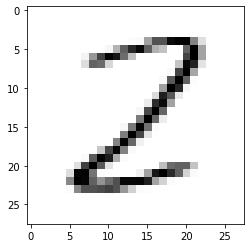

In [19]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [0]:
class MnistLeNet(nn.Module):
  def __init__(self):
    super(MnistLeNet,self).__init__()
    self.feature=nn.Sequential(
        nn.Conv2d(1, 6, kernel_size = 5), #(N, 1, 28, 28) -> (N, 6, 24, 24)
        nn.Tanh(),
        nn.AvgPool2d(2, stride = 2), #(N, 6, 24, 24) -> (N, 6, 12, 12)
        nn.Conv2d(6, 16, kernel_size = 5), #(N, 6, 12, 12) -> (N, 16, 8, 8)
        nn.Tanh(),
        nn.AvgPool2d(2, stride = 2) #(N, 16, 8, 8) -> (N, 16, 4, 4)
    )
    self.classifer=nn.Sequential(
        nn.Linear(256, 120), # (N, 256) -> (N, 120)
        nn.Tanh(),
        nn.Linear(120, 84), # (N, 120) -> (N, 84)
        nn.Tanh(),
        nn.Linear(84, 10)  # (N, 84)  -> (N, 10)
    )
  def forward(self,x):
    x=self.feature(x)
    x=x.view(x.size(0),-1)
    return self.classifer(x)

In [0]:
device = torch.device("cuda")

In [0]:
def evaluation_gpu(dataloader):
  #function to calculate the accuracy
    total, correct = 0, 0
    for data in dataloader:
      inputs, labels = data
      inputs,labels= inputs.to(device),labels.to(device)
      outputs = model(inputs)
      #max_value, max_index = torch.max(tensor,axis)
      _, pred = torch.max(outputs.data, 1)
      #here total = total + batch_size
      total += labels.size(0)
      #here if pred and lables are equal then result will be 1 and we sum them up and fetch tensor value by item()
      correct += (pred == labels).sum().item()
      #print("Prediction from Model : ",pred)
      #print("labels : ",labels)
    return(100 * correct/total)

In [0]:
def fit_gpu(trainloader,valloader,model,opt,loss_fn,epochs=50):
        #callback=StopatLossValue()
        time0=time.time()
        trainloss=[]
        valloss=[]
        trainacclist=[]
        valacclist=[]
        min_valloss=10000000.0000000
        min_trainloss=10000000.0000000
        max_valacc=0.0
        max_trainacc=0.0
        for epoch in range(epochs):
            runningtrain_loss=0
            runningval_loss=0
            #init_fn()
            for i, data in enumerate(trainloader, 0):

                inputs, labels = data
                inputs=inputs.to(device)
                labels=labels.to(device)

                #forward pass
                loss = loss_fn(model(inputs), labels)

                #backward and optimize
                opt.zero_grad()
                loss.backward()
                opt.step()
                
                #loss_arr.append(loss.item())
                runningtrain_loss += loss.item()
            #init_fn()
            for i, data in enumerate(valloader,0):
                inputs, labels = data
                inputs=inputs.to(device)
                labels=labels.to(device)

                #forward pass
                loss = loss_fn(model(inputs), labels)
                #valloss_arr.append(loss.item())
                runningval_loss += loss.item()
            avgval_loss=runningval_loss/len(valloader)
            avgtrain_loss=runningtrain_loss/len(trainloader)
            if (avgval_loss<min_valloss):
                min_valloss=avgval_loss    
                vallossmodel=copy.deepcopy(model.state_dict())
            if (avgtrain_loss<min_trainloss):
                min_trainloss=avgtrain_loss
                trainlossmodel=copy.deepcopy(model.state_dict())
            trainacc=evaluation_gpu(trainloader)
            valacc=evaluation_gpu(valloader)
            trainacclist.append(trainacc)
            valacclist.append(valacc)
            if (trainacc>max_trainacc):
                max_trainacc=trainacc
                trainaccmodel=copy.deepcopy(model.state_dict())
            if (valacc>max_valacc):
                max_trainacc=valacc
                valaccmodel=copy.deepcopy(model.state_dict())      
            print("Minimum training Loss :",min_trainloss,"| Minimum validation Loss :",min_valloss) 
            print("Epoch {} - Training loss: {}".format(epoch,avgtrain_loss ),"| validation loss: {}".format(avgval_loss))    
            print('Epoch: %d/%d, Train acc: %0.2f' % (epoch, epochs-1,trainacc ),'| val acc: %0.2f' % (valacc))
            print('------------------------------------------------------------------------------------------')
            trainloss.append(avgtrain_loss)       
            valloss.append(avgval_loss)
            #vis.line(Y=avgtrain_loss, opts=dict(showlegend=True))
        print("Training Time(in minutes) =",(time.time()-time0)/60)    
        return vallossmodel,trainlossmodel,valaccmodel,trainaccmodel,trainloss,valloss,trainacclist,valacclist

In [24]:
#Train Model On GPU
model=MnistLeNet()
model = model.to(device)
opt=optim.Adam(model.parameters())
loss_fn=nn.CrossEntropyLoss()
vallossmodel,trainlossmodel,valaccmodel,trainaccmodel,trainloss,valloss,trainacclist,valacclist=fit_gpu(trainloader,valloader,model,opt,loss_fn)

Minimum training Loss : 0.28434872944583134 | Minimum validation Loss : 0.11475449159836314
Epoch 0 - Training loss: 0.28434872944583134 | validation loss: 0.11475449159836314
Epoch: 0/49, Train acc: 96.65 | val acc: 96.65
------------------------------------------------------------------------------------------
Minimum training Loss : 0.09028884649340278 | Minimum validation Loss : 0.07179903457309031
Epoch 1 - Training loss: 0.09028884649340278 | validation loss: 0.07179903457309031
Epoch: 1/49, Train acc: 97.94 | val acc: 97.86
------------------------------------------------------------------------------------------
Minimum training Loss : 0.060989280634406784 | Minimum validation Loss : 0.06224112333670543
Epoch 2 - Training loss: 0.060989280634406784 | validation loss: 0.06224112333670543
Epoch: 2/49, Train acc: 98.42 | val acc: 97.91
------------------------------------------------------------------------------------------
Minimum training Loss : 0.04888386812323192 | Minimum va

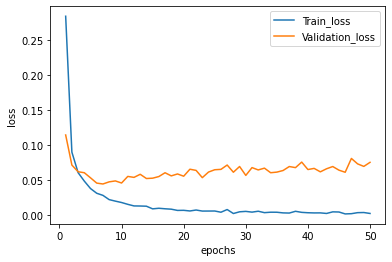

In [25]:
epochs=50
plt.plot([i for i in range(1,epochs+1)],trainloss,label="Train_loss")
plt.plot([i for i in range(1,epochs+1)],valloss,label="Validation_loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

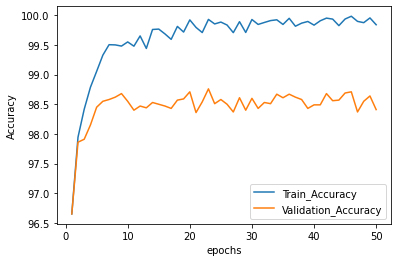

In [26]:
plt.plot([i for i in range(1,epochs+1)],trainacclist,label="Train_Accuracy")
plt.plot([i for i in range(1,epochs+1)],valacclist,label="Validation_Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
#load dict of favourable model from trainaccmodel,valaccmodel,tainlossmodel,vallossmodel
model.load_state_dict(trainaccmodel)
torch.save(model,'mnistLeNet.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type MnistLeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
loader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)

In [34]:
model_conv=nn.Sequential(*list(model.children())[0][0:4])
print(model_conv)
#model_conv=nn.Sequential(*list(model_conv.children())[0][0:4])
#print(model_conv)
for param in model_conv.parameters():
    param.requires_grad = False
model_conv=model_conv.to(device)
inputs, labels = next(iter(loader))
inputs = inputs.to(device)
outputs = model_conv(inputs)
outputs.data.shape
out_numpy=outputs.cpu().numpy()
print(out_numpy.shape)


Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
)
(8, 16, 8, 8)


In [0]:
import matplotlib.pyplot as plt

In [0]:
def conv_visual(arr,i):
    fig,axes=plt.subplots(4,4,figsize=(20,20))
    axes = axes.ravel()
    for j in np.arange(0, 16):
      axes[j].imshow(arr[i][j])
    plt.show()

tensor(4)


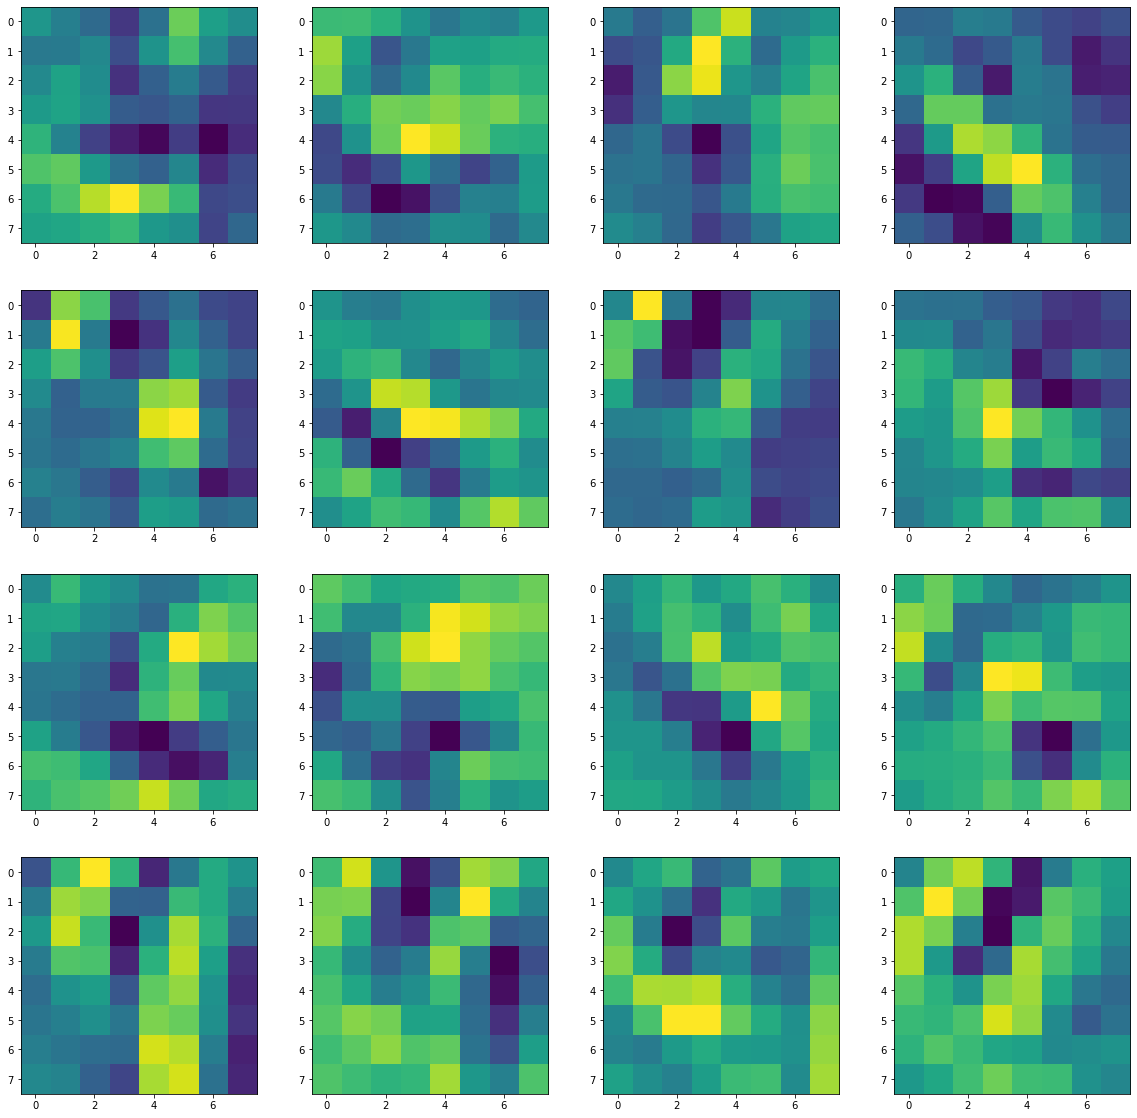

In [37]:
print(labels[3])
conv_visual(out_numpy,3)